Loading SSD classifier.
File name: test_images/image14.jpg


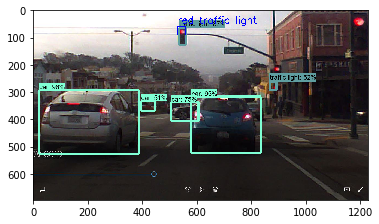

File name: test_images/image15.jpg


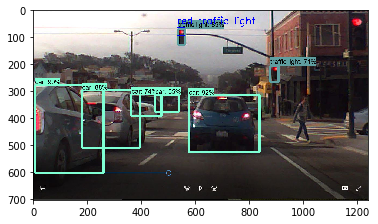

File name: test_images/image16.jpg


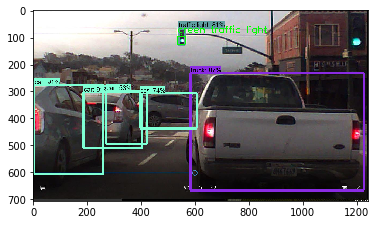

File name: test_images/image17.jpg


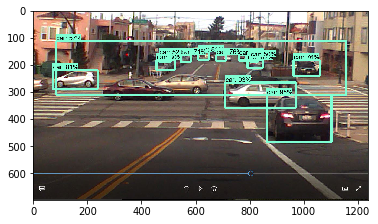

File name: test_images/image18.jpg


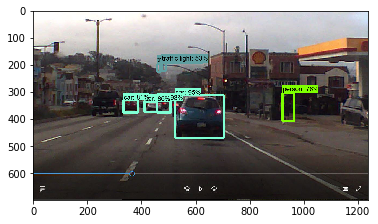

File name: test_images/image19.jpg


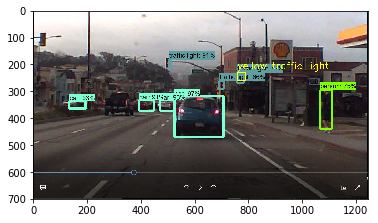

In [38]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# In[ ]:
import cv2
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import time 
import copy

# In[ ]:

# This is needed to display the images.
#get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
 
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")


# In[ ]:

from utils import label_map_util

from utils import visualization_utils as vis_util


######from my Udacity capstone project#######

def traffic_light_location(boxes, scores, classes, img_size=[600, 800, 3], score_thresh=0.2):
    # tensorflow usually operates on a set of images 
    boxes = boxes[0]
    scores = scores[0]
    classes = classes[0]
    #for i in range(len(scores)):
     #   print("testing scores[{}]: {}".format(i, scores[i])) 
      #  print("tesing  classes[{}]: {}".format(i, classes[i]))   
    output_boxes = []
    # For now only do box around highest score. NOT ROBUST.
    for i in range(len(scores)):
        # Must be a traffic light and meet threshold.
        #classes = 10 means is a traffic light
        if scores[i] > score_thresh and classes[i] == 10:
            #print("traffic light detected.  scores[{}]: {}, classes: {}, boxes: {}".format(i, scores[i], classes[i], boxes[i]))
            # Box values are between 0-1.
            left_x = int(boxes[i][1]*img_size[1])
            top_y = int(boxes[i][0]*img_size[0])
            right_x = int(boxes[i][3]*img_size[1])
            bot_y = int(boxes[i][2]*img_size[0])
            output_boxes.append([left_x, top_y, right_x, bot_y])
            
    #print("output_boxes: {}".format(output_boxes))
    
    return output_boxes
###############################################
def get_light_color(imgbox, imgo, tl_box, lower_HSV, upper_HSV):
    # retain the orignal image
    imgOrig = imgbox
    
    # use initial image without any bounding boxes to classify traffic light
    # color since the bounding boxes sometimes totally blocking the traffic light color
    img = imgo
    
    #convert rgb to bgr
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    colorID = "UNKNOWN"
    # median blur the image
    img = cv2.medianBlur(img, 5)
    # Convert image to HSV
    hsvImg = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
    # Threshold the HSV image to get only selected(red, green, or yellow) colors
    mask = cv2.inRange(hsvImg, lower_HSV, upper_HSV) 
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(img,img, mask= mask)
    
    #mask out the area in image that has no traffic lights
    #create a black image
    polygon_img = np.zeros(img.shape, np.uint8)
    
    for j in range(len(tl_box)):
        #draw a polygon
        left_x = tl_box[j][0]
        top_y = tl_box[j][1]
        right_x = tl_box[j][2]
        bot_y = tl_box[j][3]
        #print("At index: {}, left_x: {}, top_y:  {}, right_x: {}, bot_y: {}".format(j, left_x, top_y, right_x, bot_y))
        pts = np.array([[left_x, top_y], [right_x, top_y], [right_x, bot_y], [left_x, bot_y]])
        cv2.fillPoly(polygon_img, pts=[pts], color=(255,255,255))
        res1 = cv2.bitwise_and(res,res,mask=polygon_img[:,:,1])
        
        
        # Debug.
        #cv2.imwrite('img.png',img)
        #cv2.imwrite('poly.png',polygon_img)

        #cv2.imwrite('combined.jpg',cv2.bitwise_and(
            #img,img,mask=polygon_img[:,:,1]))
        
        #brightest spot
        a = np.array(res1)
        #print(a.max(), np.unravel_index(a.argmax(), a.shape))
        brighty = np.unravel_index(a.argmax(), a.shape)[0]
        brightx = np.unravel_index(a.argmax(), a.shape)[1]
        #print("Brightest spot, brightx: {}, birghty: {}".format(brightx, brighty)) 

        #color hsv range boolean
        greenColor = np.all(lower_HSV == np.array([60, 125, 125])) and np.all(upper_HSV == np.array([120,255,255]))
        redColor = np.all(lower_HSV == np.array([170, 125, 125])) and np.all(upper_HSV == np.array([179,255,255]))
        yellowColor = np.all(lower_HSV == np.array([5, 150, 150])) and np.all(upper_HSV == np.array([40,255,255]))

        #divide the bounding box into 3 regions: red, yellow, and green
        upperYellowy = top_y + (bot_y - top_y)/3
        lowerYellowy = bot_y - (bot_y - top_y)/3
        #print("Average height of traffic light: {}".format((bot_y - top_y)/3))
        #print("top_y: {}, upperYellowy: {}, lowerYellowy: {}, bot_y:{}".format(top_y, upperYellowy, lowerYellowy, bot_y))
        #put the original image back
        img = imgOrig
        
        #average height of the traffic light has to be over 10 pixels for red, yellow, and green 3 color box type
        if (((brightx == 0) and (brighty == 0)) == False and (bot_y - top_y)/3 > 10):
            if (brighty >= lowerYellowy and brighty <= bot_y) and (greenColor == True):
                #print("********* G R E E N *********")
                cv2.rectangle(img, (brightx -15, brighty - 15), (brightx + 15, brighty + 15), (0,255,0),2)
                cv2.putText(img, "green traffic light", (brightx-15, brighty -27), 0, 1.2, (0,255,0),2)
                colorID = "GREEN"
                #print("At time: {} sec, colorID: TrafficLight.GREEN ".format(str(time.clock())))
            elif (brighty >= top_y and brighty < upperYellowy) and (redColor == True):
                #print("*********   R E D   *********")
                cv2.rectangle(img, (brightx -15, brighty - 15), (brightx + 15, brighty + 15), (0,0,255),2)
                cv2.putText(img, "red traffic light", (brightx-15, brighty -27), 0, 1.2, (0,0,255),2)
                colorID = "RED"
               #print("At time: {} sec, colorID: TrafficLight.RED".format(str(time.clock())))
            elif (brighty >= upperYellowy and brighty < lowerYellowy) and (yellowColor == True):
                #print("******** Y E L L O W ********")
                cv2.rectangle(img, (brightx -15, brighty - 15), (brightx + 15, brighty + 15), (255,255,0),2)
                cv2.putText(img, "yellow traffic light", (brightx-15, brighty -27), 0, 1.2, (255,255,0),2)
              
                colorID = "YELLOW"
               #print("At time: {} sec, colorID: TrafficLight.YELLOW".format(str(time.clock())))
            #plt.imshow(img)
            #plt.show()
    return colorID, img

    
#############################################        
def download_frozen_model():
    print("Downloading frozen model.")
    MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
    MODEL_FILE = MODEL_NAME + '.tar.gz'
    DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

    # Path to frozen detection graph. This is the actual model that is used for the object detection.
    PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

    # List of the strings that is used to add correct label for each box.
    PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

    NUM_CLASSES = 90


# ## Download Model

    opener = urllib.request.URLopener()
    opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
    tar_file = tarfile.open(MODEL_FILE)
    for file in tar_file.getmembers():
       file_name = os.path.basename(file.name)
       if 'frozen_inference_graph.pb' in file_name:
          tar_file.extract(file, os.getcwd())

#############################################
def loadSSD():
    #load classifier
    MODEl_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
    PATH_TO_MODEL = 'frozen_inference_graph.pb'
    detection_graph = tf.Graph()

    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()

        with tf.gfile.GFile("/".join([MODEl_NAME,PATH_TO_MODEL]), 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    return detection_graph
#do a SSD image processing function##############
def process_image(image):
    #Retain the initial image before ssd bounding boxes are drawn.
    #create a deep copy 
    imgo = copy.deepcopy(image)
    
    # List of the strings that is used to add correct label for each box.
    PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

    NUM_CLASSES = 90

    #Loading label map
    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    categories =      label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
    category_index =     label_map_util.create_category_index(categories)
    
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:

            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image, axis=0)
    # Actual detection.
            (boxes, scores, classes, num) = sess.run(
                  [detection_boxes, 
                   detection_scores, 
                   detection_classes, 
                   num_detections],
            feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                 image,
                 np.squeeze(boxes),
                 np.squeeze(classes).astype(np.int32),
                 np.squeeze(scores),
                 category_index,
                 use_normalized_coordinates=True,
                 line_thickness=8)
           #print("Tensorflow image process: boxes: {}".format(boxes))
           #print("scores: {}".format(scores))
           #print("classes: {}".format(classes))
           #print("num: {}".format(num))

    #plt.imshow(image)
    #plt.show()
    
    ##from my code in Udacity CapstoneProject for traffic light color classification########
    #initialize all variables
    yellowLight = False
    redLight = False
    greenLight = False
    yellowImg = image
    redImg = image
    greenImg = image
    result = image

    #The size of one traffic light is about 50 in x direction,125 in y direction
    #The center of the image is:
    x = image.shape[1]/2 
    y = image.shape[0]/2 

    tl_loc = traffic_light_location(boxes, scores, classes, image.shape)
    #print(tl_loc)
    # No traffic lights found, look in Bernards original location.
    if len(tl_loc) == 0:
        tl_loc = 0 #print("No Lights found by NN!")
    else:     
        ###################green color detection##########
        # define range of green color in HSV
        lower_green = np.array([60,125,125]) #100,100])
        upper_green = np.array([120,255,255])
        [clr_ID, greenImg] = get_light_color(image, imgo, tl_loc, lower_green, upper_green)
        if (clr_ID == "GREEN"):
            greenLight = True
        ##################red color detection#################
        # define range of red color in HSV
        lower_red = np.array([170,125,125]) 
        upper_red = np.array([179,255,255])
        [clr_ID, redImg] = get_light_color(image, imgo, tl_loc, lower_red, upper_red)
        if (clr_ID == "RED"):
            redLight = True


        ###########yellow traffic light detection###########
        # define range of orange color in HSV
        lower_yellow = np.array([5,150,150]) 
        upper_yellow = np.array([40,255,255]) #real amber traffic light works 15,255,255])
        [clr_ID, yellowImg] = get_light_color(image, imgo, tl_loc, lower_yellow, upper_yellow)
        if (clr_ID == "YELLOW"):
            yellowLight = True
            	
        if ((yellowLight == True) and (redLight == False) 
             and (greenLight == False)):
            clr_ID = "YELLOW"
            result = yellowImg

        elif ((yellowLight == False) and (redLight == True) 
            and (yellowLight == False)):
            clr_ID = "RED"
            result = redImg

        elif ((yellowLight == False) and (redLight == False) 
             and (greenLight == True)):
            clr_ID = "GREEN" 
            result = greenImg
        else:
            clr_ID = "UNKNOWN"
            result = image
        
        #plt.imshow(result)
        #plt.show()
        #print("Traffic Light color_ID: {}".format(clr_ID))
    return result        

def SSDobjDet(Vin, Vout):
    clip1 = VideoFileClip(Vin)
    white_clip = clip1.fl_image(process_image)
    %time white_clip.write_videofile(Vout, audio=False)
    return Vout

def videoAnnotate(VideoIn, VideoOut):
    HTML("""
    <video width="960" height="540" controls>
    <source src="{0}">
    </video>
    """.format(SSDobjDet(VideoIn, VideoOut)
        ))  
            
####main run######
#Download frozen model
#download_frozen_model()

#load the SSD classifier
print("Loading SSD classifier.")
global detection_graph
detection_graph = loadSSD()
"""
dir = "test_images/image" 
for i in range(13,19):
    FNum = "".join([dir, str(i+1)])
    FName = ".".join([FNum, "jpg"])
    print("File name: {}".format(FName))
    plt.imshow(process_image(cv2.cvtColor(cv2.imread(FName), cv2.COLOR_BGR2RGB)))
    plt.show()
"""    
## produce a video that finds objects ########
#videoAnnotate("test_videos/MOVI0017_1secto1min31sec.mp4", "test_videos/MOVI0017SSD_1secto1min31sec.mp4")
#videoAnnotate("test_videos/MOVI0017_1min32secto3min2sec.mp4", "test_videos/MOVI0017SSD_1min32secto3min2sec.mp4")
videoAnnotate("test_videos/MOVI0019_1min32secto3min2sec.mp4", "test_videos/MOVI0019SSD_1min32secto3min2sec.mp4")
#videoAnnotate("test_videos/MOVI0019_69to79sec.mp4", "test_videos/MOVI0019_69to79secSSD.mp4")